In [1]:
# libraries
%load_ext autoreload
%autoreload 2

import numpy as np
import soundfile as sf
import sounddevice as sd
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from scipy import signal, fft

from PDM2PCM import *
from PCM2PDM import *
from Serialize import *
from PlotSuite import *

In [2]:
def cic_compensator_response(c=2**13, N=3, R=10, M=1, order=31, cutoff=25, att=50, fs=1000, freq_points=512, plot=False): 
    # cic filter response
    freq_cic = np.arange(start=0, stop=0.5, step=1/(2*freq_points))
    spec_cic = np.zeros(len(freq_cic))
    spec_cic[1:] = (np.sin(np.pi*freq_cic[1:]*R*M) / np.sin(np.pi*freq_cic[1:]))**N # cic response
    spec_cic[0] = (R*M)**N # DC gain
    mag_cic = np.abs(spec_cic) # cic mag. response
    mag_cic = mag_cic/np.max(mag_cic) # cic mag. response norm.
    mag_cic_db = 20*np.log10(mag_cic) # cic mag. response db
    
    R = R/2
    # ideal fir compensator response (inverse of cic)
    fir_freq_points = freq_points
    freq_fir = np.linspace(start=0, stop=1, num=fir_freq_points)
    freq_cic = np.arange(start=0, stop=np.round(fir_freq_points*cutoff/(fs/(2*R))))
    freq_cic = (1/R)*freq_cic/fir_freq_points
    inv_cic = np.zeros(len(freq_fir))
    inv_cic[1:len(freq_cic)] = 1/((1/(R*M)**N)*(np.sin(np.pi*freq_cic[1:]*R*M/2) / np.sin(np.pi*freq_cic[1:]/2))**N)
    inv_cic[0] = 1
    
    # actual fir compensator response
    fir_coeffs = signal.firwin2(numtaps=order, freq=freq_fir, gain=inv_cic, nyq=None, window=('chebwin',att))
    spec_comp_filt = fft.fft(fir_coeffs, 2*freq_points)
    spec_comp_filt = spec_comp_filt[:freq_points]
    mag_comp_filt = np.abs(spec_comp_filt)
    mag_comp_filt_db = 20*np.log10(mag_comp_filt)

    # cic mainlobe response
    cic_mainlobe_freq = 0.5*(2/R)*np.arange(start=0, stop=freq_points)/freq_points
    cic_mainlobe = np.zeros(len(cic_mainlobe_freq))
    cic_mainlobe[1:] = ((1/(R*M))*(np.sin(np.pi*cic_mainlobe_freq[1:]*R*M/2) / np.sin(np.pi*cic_mainlobe_freq[1:]/2)))**N
    cic_mainlobe[0] = 1

    # cascade filter response
    mag_cascaded_filt = np.abs(cic_mainlobe * spec_comp_filt)
    mag_cascaded_filt_db = 20*np.log10(mag_cascaded_filt)

    freq_desired_fir = np.arange(start=0, stop=fir_freq_points) * (fs/(2*R)) / (fir_freq_points)
    freq_actual_fir =  np.arange(start=0, stop=freq_points)     * (fs/(2*R)) / (freq_points)
    freq_cic =         np.arange(start=0, stop=freq_points)     * (fs/2)     / (freq_points)

    fir_coeffs = (fir_coeffs*c).astype(np.int16)

    if plot: 
    
        fig, axs = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(10,8))
        
        axs[0,0].semilogx(freq_actual_fir, mag_cascaded_filt_db, label="Filtros em cascata", color='black', linestyle='solid')
        axs[0,0].semilogx(freq_cic[freq_cic<=freq_actual_fir[-1]], mag_cic_db[freq_cic<=freq_actual_fir[-1]], label="Filtro CIC", color='black', linestyle='dashdot')
        axs[0,0].semilogx(freq_actual_fir, mag_comp_filt_db, label="Filtro FIR Comp.", color='black', linestyle='dotted')
        
        axs[0,1].semilogx(freq_cic, mag_cic_db, label='Filtro CIC', color='black')

        axs[1,0].stem(fir_coeffs, basefmt=" ", label='Coeficientes do filtro FIR compensador', linefmt='black', markerfmt='ko')

        axs[1,1].semilogx(freq_desired_fir, inv_cic, label="Resposta desejada", color='black', linestyle='solid')
        axs[1,1].semilogx(freq_actual_fir, mag_comp_filt, label="Resposta real", color='black', linestyle='dashed')

        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.4)

        axs[0,1].set_ylim([-70,2])
        axs[0,0].set_xlabel('Frequência (Hz)'), axs[0,1].set_xlabel('Frequência (Hz)'), axs[1,0].set_xlabel('#Coeficientes'), axs[1,1].set_xlabel('Frequência (Hz)')
        axs[0,0].set_ylabel('Ganho do filtro (dB)'), axs[0,1].set_ylabel('Ganho do filtro (dB)'), axs[1,0].set_ylabel('Amplitude'), axs[1,1].set_ylabel('Ganho do filtro')
        axs[0,0].legend(), axs[1,1].legend()
        axs[0,0].grid(True, which="both"), axs[0,1].grid(True, which="both"), axs[1,0].grid(True, which="both"), axs[1,1].grid(True, which="both")
        axs[0,0].set_title("Resposta dos filtros em cascata"), axs[0,1].set_title("Resposta do filtro CIC"), axs[1,0].set_title("Coeficientes do filtro FIR compensador"), axs[1,1].set_title("Resposta do filtro FIR compensador")

        # np.set_printoptions(threshold=sys.maxsize, formatter={'int':hex})
    return fir_coeffs

In [3]:
fs    = 5e6 # pdm sampling frequency
N     = 2   # number of CIC stages
R     = 16  # decimation rate
M     = 1   # differential delay in the comb section stages of the filter
order = 64  # fir compensator order

# Resposta do CIC

In [6]:
def cic_response_sweep():
    fs    = 5e6 # pdm sampling frequency
    R     = 16  # decimation rate
    freq_points = 512

    # cic filter response
    freq_cic = np.arange(start=0, stop=0.5, step=1/(2*freq_points))
    spec_cic = np.zeros(len(freq_cic))
    mag_cic_db1 = np.zeros((len(freq_cic),3))
    mag_cic_db2 = np.zeros((len(freq_cic),3))

    M = 1
    for N in [1,2,3]:
        spec_cic[1:] = (np.sin(np.pi*freq_cic[1:]*R*M) / np.sin(np.pi*freq_cic[1:]))**N # cic response
        spec_cic[0] = (R*M)**N # DC gain
        mag_cic = np.abs(spec_cic) # cic mag. response
        mag_cic = mag_cic/np.max(mag_cic) # cic mag. response norm.
        mag_cic_db1[:,N-1] = 20*np.log10(mag_cic) # cic mag. response db

    M = 2
    for N in [1,2,3]:
        spec_cic[1:] = (np.sin(np.pi*freq_cic[1:]*R*M) / np.sin(np.pi*freq_cic[1:]))**N # cic response
        spec_cic[0] = (R*M)**N # DC gain
        mag_cic = np.abs(spec_cic) # cic mag. response
        mag_cic = mag_cic/np.max(mag_cic) # cic mag. response norm.
        mag_cic_db2[:,N-1] = 20*np.log10(mag_cic) # cic mag. response db

    freq_cic = np.arange(start=0, stop=freq_points) * (fs/2) / (freq_points)

    return freq_cic, mag_cic_db1, mag_cic_db2

freq_cic, mag_cic_db1, mag_cic_db2 = cic_response_sweep()

(Text(0.5, 1.0, 'Resposta do filtro CIC (R=16, M=1)'),
 Text(0.5, 1.0, 'Resposta do filtro CIC (R=16, M=2)'))

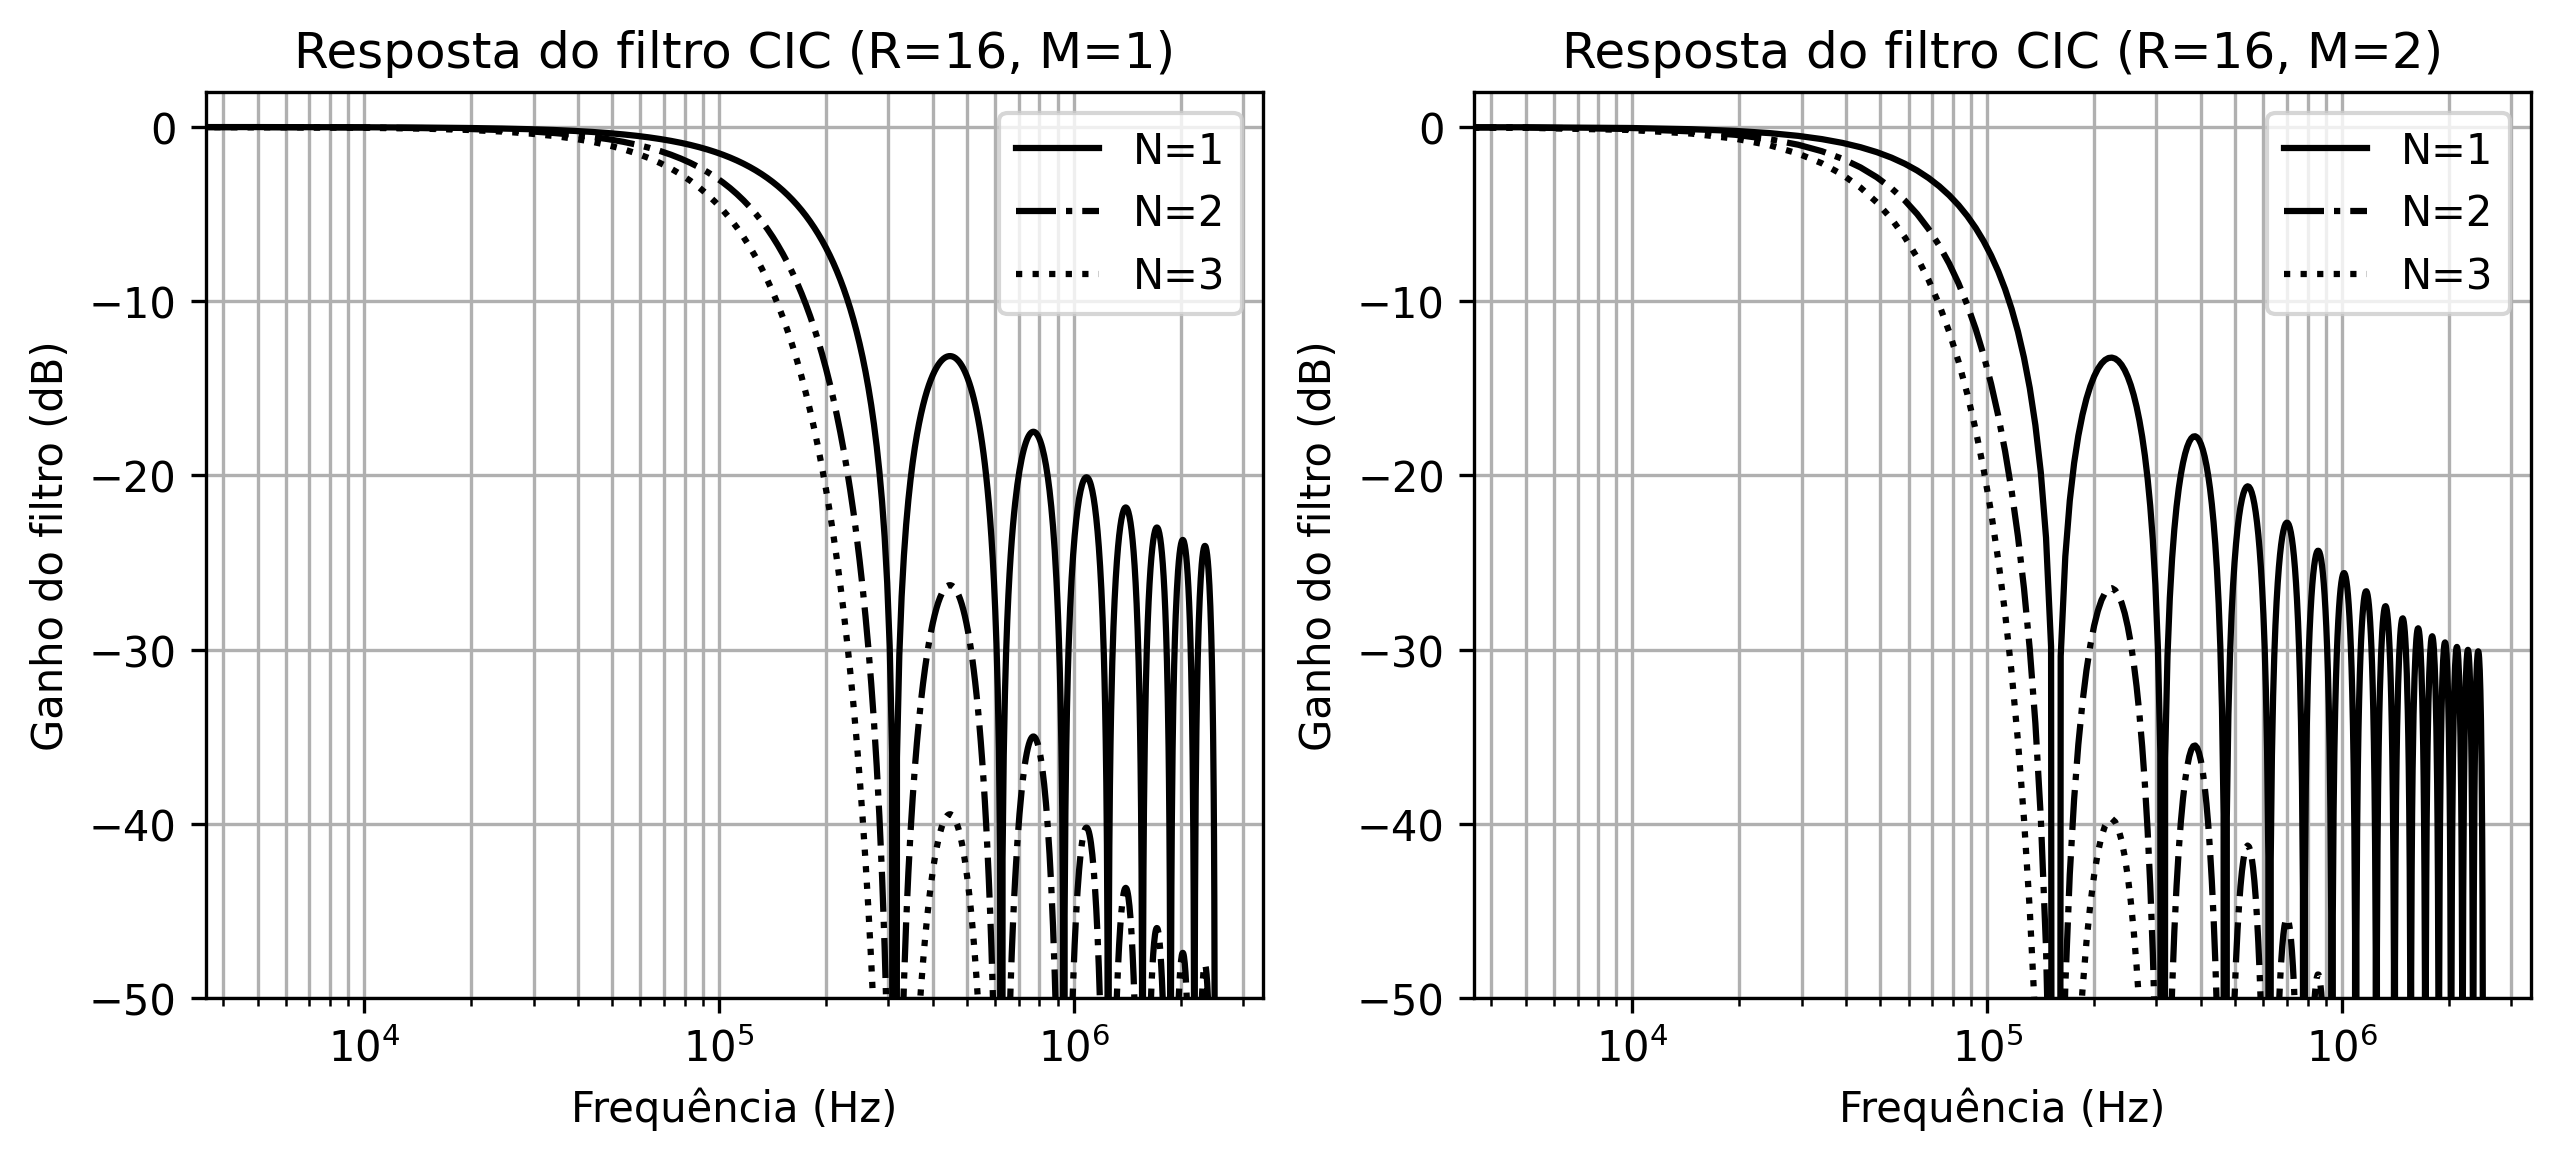

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(10,4))

axs[0].semilogx(freq_cic, mag_cic_db1[:,0], label="N=1", color='black', linestyle='solid')
axs[0].semilogx(freq_cic, mag_cic_db1[:,1], label="N=2", color='black', linestyle='dashdot')
axs[0].semilogx(freq_cic, mag_cic_db1[:,2], label="N=3", color='black', linestyle='dotted')

axs[1].semilogx(freq_cic, mag_cic_db2[:,0], label="N=1", color='black', linestyle='solid')
axs[1].semilogx(freq_cic, mag_cic_db2[:,1], label="N=2", color='black', linestyle='dashdot')
axs[1].semilogx(freq_cic, mag_cic_db2[:,2], label="N=3", color='black', linestyle='dotted')

range_ = [-50,2]
axs[0].set_ylim(range_), axs[1].set_ylim(range_)
axs[0].set_xlabel('Frequência (Hz)'), axs[1].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Ganho do filtro (dB)'), axs[1].set_ylabel('Ganho do filtro (dB)')
axs[0].legend(), axs[1].legend()
axs[0].grid(True, which="both"), axs[1].grid(True, which="both")
axs[0].set_title("Resposta do filtro CIC (R=16, M=1)"), axs[1].set_title("Resposta do filtro CIC (R=16, M=2)")

# Resposta do FIR

In [4]:
def fir_response_sweep(order=64, r1=16, r2=8, r3=4): 
    fs    = 5e6 # pdm sampling frequency
    N     = 2   # number of CIC stages
    R     = r1  # decimation rate
    M     = 1   # differential delay in the comb section stages of the filter
    # order = 64  # fir compensator order
    freq_points = 512
    att = 300
    cutoff=90e3
    
    # cic filter response
    freq_cic = np.arange(start=0, stop=0.5, step=1/(2*freq_points))
    spec_cic = np.zeros(len(freq_cic))
    spec_cic[1:] = (np.sin(np.pi*freq_cic[1:]*R*M) / np.sin(np.pi*freq_cic[1:]))**N # cic response
    spec_cic[0] = (R*M)**N # DC gain
    mag_cic = np.abs(spec_cic) # cic mag. response
    mag_cic = mag_cic/np.max(mag_cic) # cic mag. response norm.
    mag_cic_db = 20*np.log10(mag_cic) # cic mag. response db
    
    R = r2
    # ideal fir compensator response (inverse of cic)
    fir_freq_points = freq_points
    freq_fir = np.linspace(start=0, stop=1, num=fir_freq_points)
    freq_cic = np.arange(start=0, stop=np.round(fir_freq_points*cutoff/(fs/(2*R))))
    freq_cic = (1/R)*freq_cic/fir_freq_points
    inv_cic = np.zeros(len(freq_fir))
    inv_cic[1:len(freq_cic)] = 1/((1/(R*M)**N)*(np.sin(np.pi*freq_cic[1:]*R*M/2) / np.sin(np.pi*freq_cic[1:]/2))**N)
    inv_cic[0] = 1
    fir_coeffs = signal.firwin2(numtaps=order, freq=freq_fir, gain=inv_cic, nyq=None, window=('chebwin',att))
    spec_comp_filt = fft.fft(fir_coeffs, 2*freq_points)
    spec_comp_filt = spec_comp_filt[:freq_points]
    mag_comp_filt = np.abs(spec_comp_filt)

    R = r3
    freq_fir = np.linspace(start=0, stop=1, num=fir_freq_points)
    freq_cic = np.arange(start=0, stop=np.round(fir_freq_points*cutoff/(fs/(2*R))))
    freq_cic = (1/R)*freq_cic/fir_freq_points
    
    # actual fir compensator response
    fir_coeffs = signal.firwin2(numtaps=order, freq=freq_fir, gain=inv_cic, nyq=None, window=('chebwin',att))
    spec_comp_filt = fft.fft(fir_coeffs, 2*freq_points)
    spec_comp_filt = spec_comp_filt[:freq_points]
    mag_comp_filt_db = 20*np.log10(np.abs(spec_comp_filt))

    # cic mainlobe response
    cic_mainlobe_freq = 0.5*(2/R)*np.arange(start=0, stop=freq_points)/freq_points
    cic_mainlobe = np.zeros(len(cic_mainlobe_freq))
    cic_mainlobe[1:] = ((1/(R*M))*(np.sin(np.pi*cic_mainlobe_freq[1:]*R*M/2) / np.sin(np.pi*cic_mainlobe_freq[1:]/2)))**N
    cic_mainlobe[0] = 1

    # cascade filter response
    mag_cascaded_filt = np.abs(cic_mainlobe * spec_comp_filt)
    mag_cascaded_filt_db = 20*np.log10(mag_cascaded_filt)

    R = r2
    freq_desired_fir = np.arange(start=0, stop=fir_freq_points) * (fs/(2*R)) / (fir_freq_points)
    R = r3
    freq_actual_fir =  np.arange(start=0, stop=freq_points)     * (fs/(2*R)) / (freq_points)
    freq_cic =         np.arange(start=0, stop=freq_points)     * (fs/2)     / (freq_points)

    return freq_actual_fir, freq_desired_fir, freq_cic[freq_cic<=freq_actual_fir[-1]], mag_cascaded_filt_db, mag_cic_db[freq_cic<=freq_actual_fir[-1]], mag_comp_filt_db, inv_cic, mag_comp_filt

C:\Users\levyg\AppData\Local\Temp/ipykernel_19284/908982905.py:43: RuntimeWarning: divide by zero encountered in log10
  mag_comp_filt_db = 20*np.log10(np.abs(spec_comp_filt))
C:\Users\levyg\AppData\Local\Temp/ipykernel_19284/908982905.py:53: RuntimeWarning: divide by zero encountered in log10
  mag_cascaded_filt_db = 20*np.log10(mag_cascaded_filt)
C:\Users\levyg\AppData\Local\Temp/ipykernel_19284/908982905.py:43: RuntimeWarning: divide by zero encountered in log10
  mag_comp_filt_db = 20*np.log10(np.abs(spec_comp_filt))
C:\Users\levyg\AppData\Local\Temp/ipykernel_19284/908982905.py:53: RuntimeWarning: divide by zero encountered in log10
  mag_cascaded_filt_db = 20*np.log10(mag_cascaded_filt)


(Text(0.5, 1.0, 'Resposta dos filtros em cascata (N=2, R=16, M=1)'),
 Text(0.5, 1.0, 'Resposta do filtro FIR compensador'))

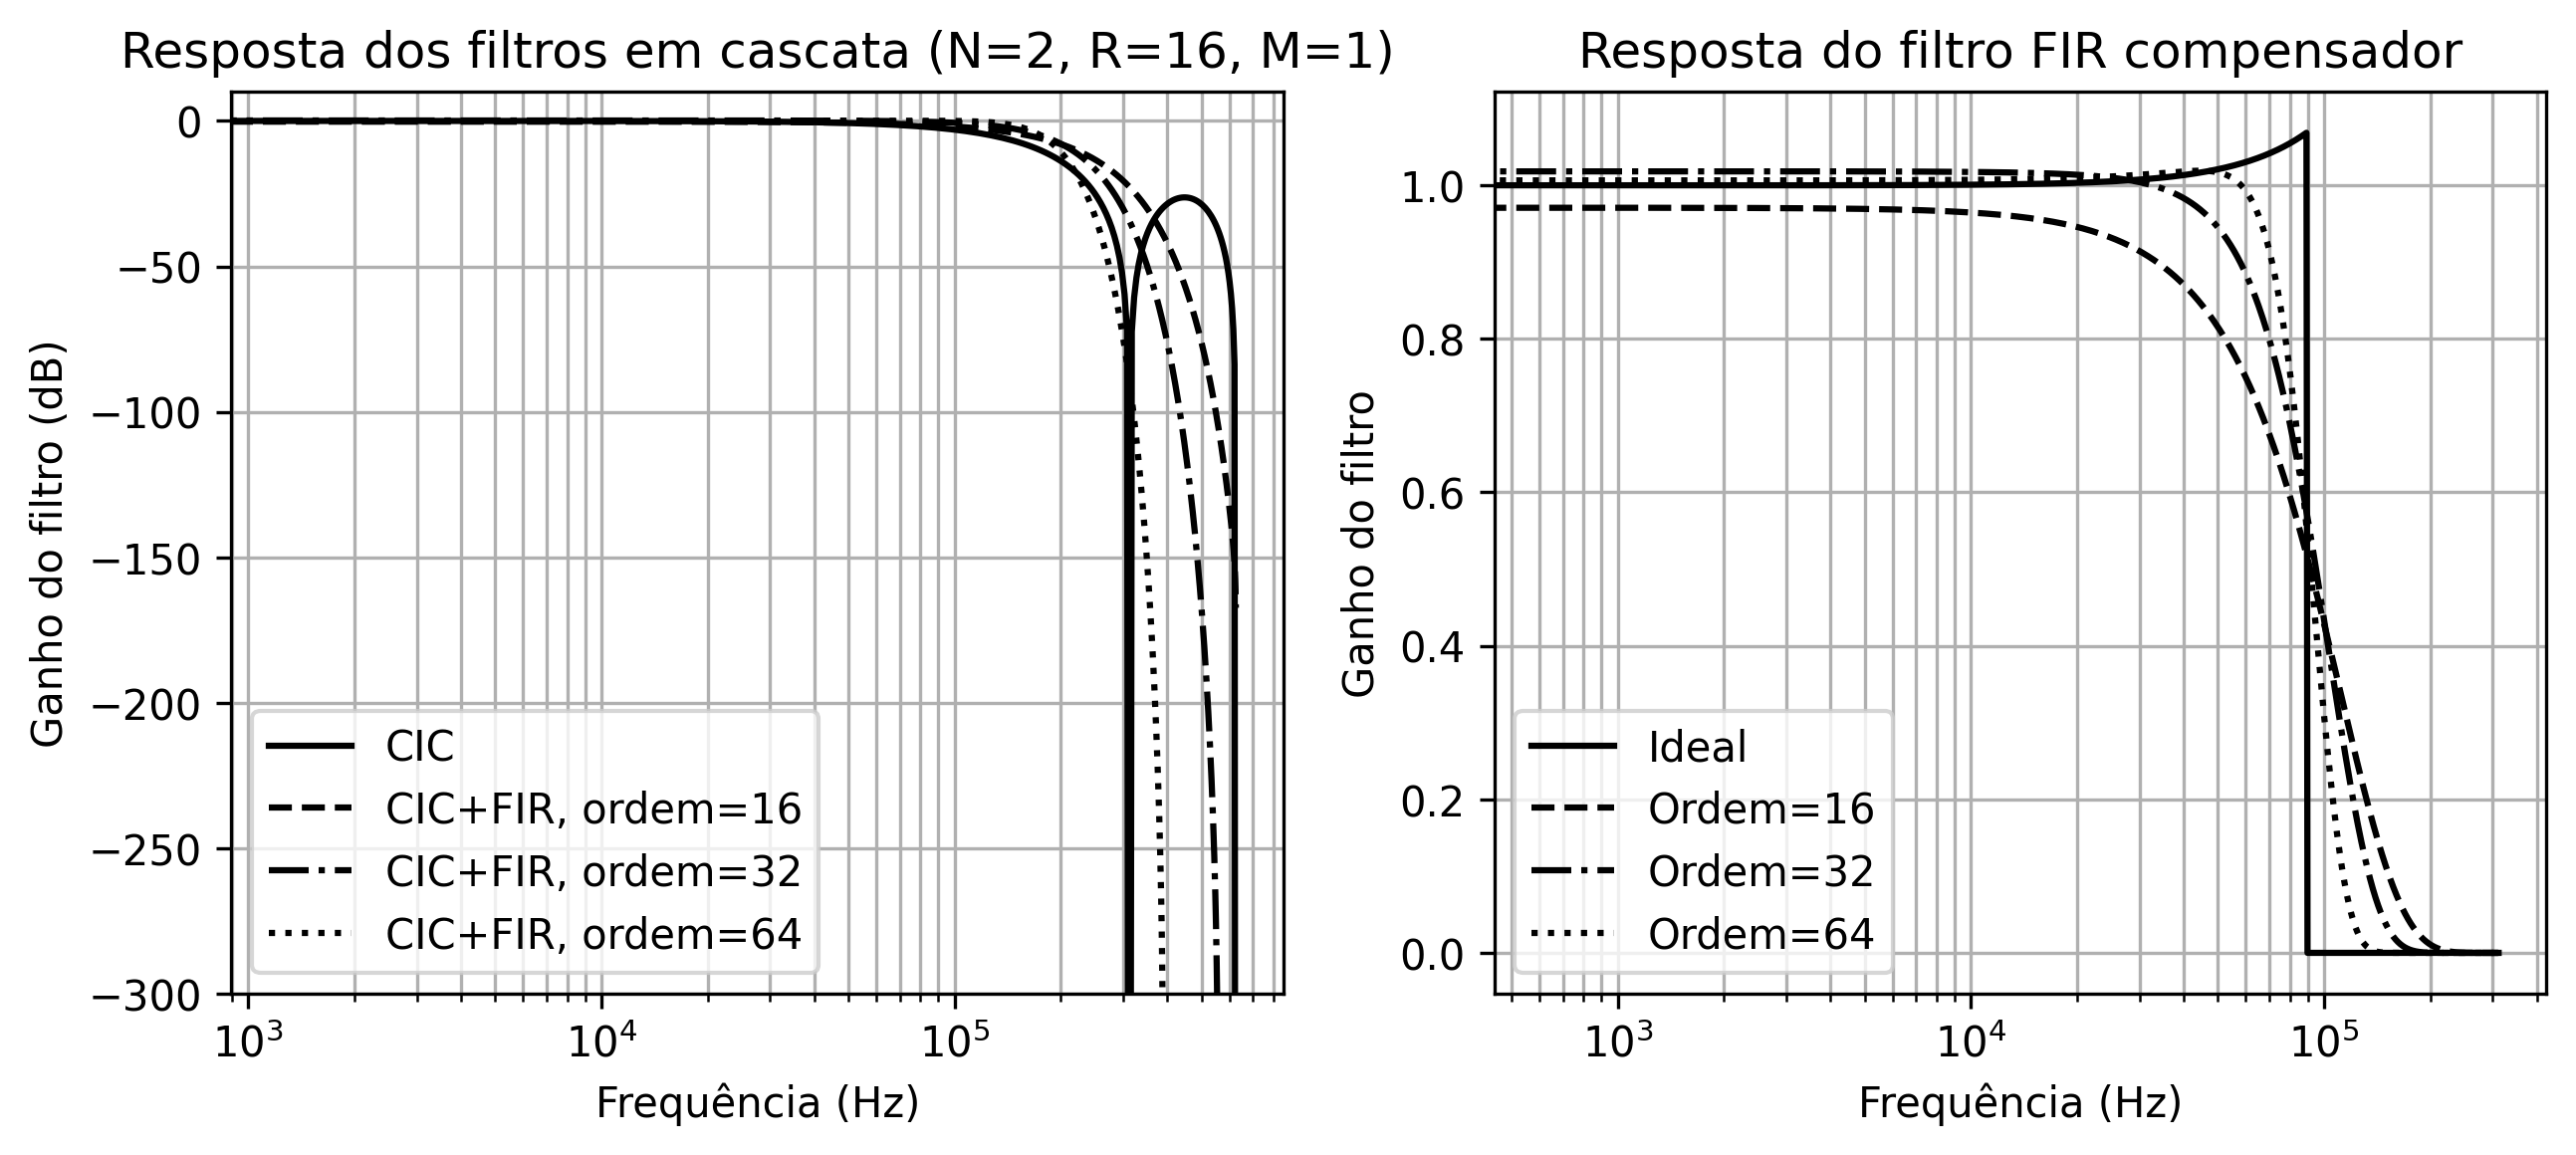

In [5]:
orders = [16, 32, 64]
# orders = [64, 128, 256]
styles = ['dashed', 'dashdot', 'dotted']

r1, r2, r3 = 16, 8, 3.99

fig, axs = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(10,4))

for (index, order) in enumerate(orders):
    freq_actual_fir, freq_desired_fir, freq_cic, mag_cascaded_filt_db, mag_cic_db, mag_comp_filt_db, inv_cic, mag_comp_filt = fir_response_sweep(order, r1, r2, r3)
    
    if index==0:
        axs[0].semilogx(freq_cic, mag_cic_db, label="CIC", color='black', linestyle='solid')
        axs[1].semilogx(freq_desired_fir, inv_cic, label="Ideal", color='black', linestyle='solid')

    axs[0].semilogx(freq_actual_fir, mag_cascaded_filt_db, label="CIC+FIR, ordem=%d" % order, color='black', linestyle=styles[index])
    # axs[0].semilogx(freq_actual_fir, mag_comp_filt_db, label="FIR, ordem=%d" % order, color='black', linestyle='dotted')
    
    axs[1].semilogx(freq_desired_fir, mag_comp_filt, label="Ordem=%d" % order, color='black', linestyle=styles[index])

range_ = [-300,10]
axs[0].set_ylim(range_)
axs[0].set_xlabel('Frequência (Hz)'), axs[1].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Ganho do filtro (dB)'), axs[1].set_ylabel('Ganho do filtro')
axs[0].legend(), axs[1].legend()
axs[0].grid(True, which="both"), axs[1].grid(True, which="both")
axs[0].set_title("Resposta dos filtros em cascata (N=2, R=16, M=1)"), axs[1].set_title("Resposta do filtro FIR compensador")